In [22]:
import pandas as pd
import math as mt
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [23]:
EPOCH = 10
BACK = 1
MUN = 10
DENSE = 1


def make_dataset(data, back):
    
    dataX, dataY = [], []
    for i in range(len(data)-back-1):
        a = data[i:(i+back), 0]
        dataX.append(a)
        dataY.append(data[i + back, 0])
        
    return np.array(dataX), np.array(dataY)

For municipality 0 the RNN is running
Epoch 1/10
517/517 [==============================] - 1s 956us/step - loss: 0.0184
Epoch 2/10
517/517 [==============================] - 0s 934us/step - loss: 0.0122
Epoch 3/10
517/517 [==============================] - 0s 888us/step - loss: 0.0114
Epoch 4/10
517/517 [==============================] - 0s 929us/step - loss: 0.0115
Epoch 5/10
517/517 [==============================] - 0s 894us/step - loss: 0.0114
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.0115
Epoch 7/10
517/517 [==============================] - 0s 903us/step - loss: 0.0117
Epoch 8/10
517/517 [==============================] - 0s 913us/step - loss: 0.0115
Epoch 9/10
517/517 [==============================] - 0s 927us/step - loss: 0.0117
Epoch 10/10
517/517 [==============================] - 0s 914us/step - loss: 0.0118
For municipality 1 the RNN is running
Epoch 1/10
517/517 [==============================] - 1s 960us/step - loss: 0.0646
Epoch 2/10
5

517/517 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.0140A: 0s - loss: 0.014
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.0139
Epoch 8/10
517/517 [==============================] - 1s 997us/step - loss: 0.0141
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 10/10
517/517 [==============================] - 1s 986us/step - loss: 0.0144
The total RMSE for AR Method is 242.6
The total RMSE for RNN Method is 54.5


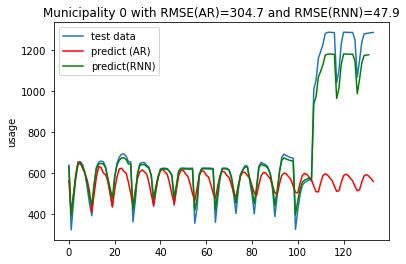

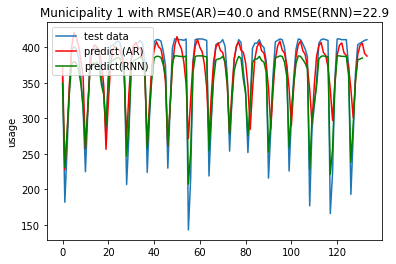

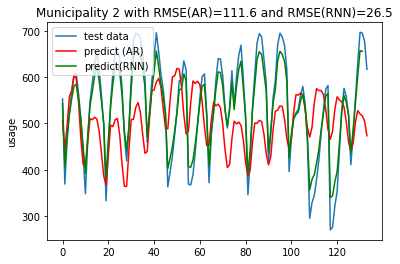

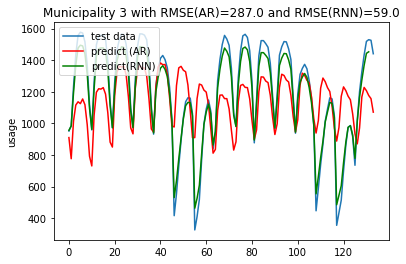

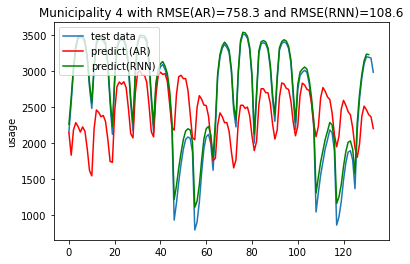

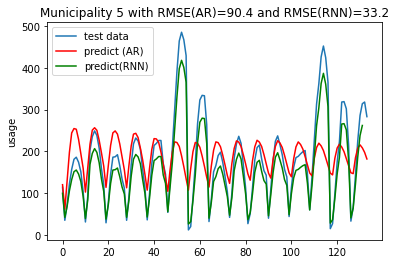

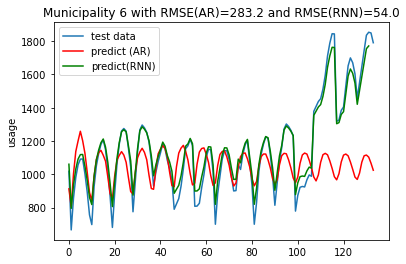

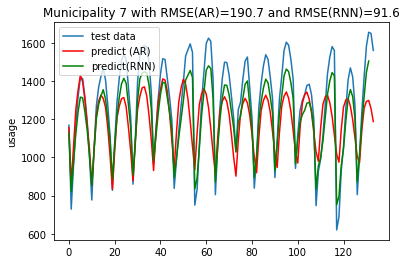

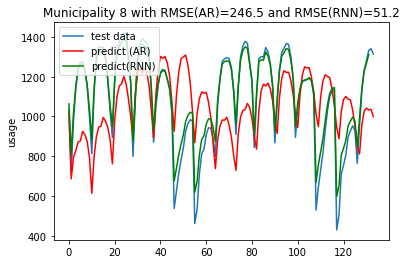

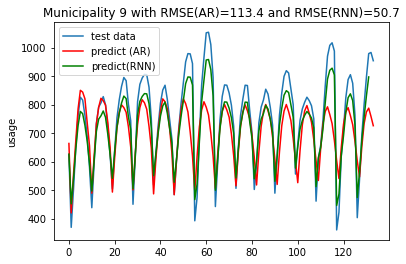

In [24]:
my_input = pd.read_csv('municipality_bus_utilization.csv')
trimmed_input = my_input.drop('total_capacity',axis=1)
sorted_input = trimmed_input.sort_values(["municipality_id", "timestamp"])


rmse = [[0]*MUN,[0]*MUN]

for i in range(0,MUN): #for each municipality
    
    cur_mun = sorted_input.loc[sorted_input['municipality_id'] == i]
    cur_mun = cur_mun.reset_index()
    
    data = {'timestamp': [],  'municipality_id': [],  'usage': []}
    del_mun = pd.DataFrame(data)
    
    for j in range(0,len(cur_mun)):
        if(j%2 == 1):            #take even rows
            #take the max usage of two consecutive rows
            cur_max = max(cur_mun.iloc[j-1]['usage'],cur_mun.iloc[j]['usage'])
            cur_row = \
            {'timestamp': cur_mun.iloc[j]['timestamp'],  'municipality_id': cur_mun.iloc[j]['municipality_id'],  'usage':cur_max}
            del_mun = del_mun.append(cur_row,ignore_index=True)
            
    #partition over time to train and test
    train = del_mun.loc[del_mun['timestamp'] < "2017-08-05"].reset_index()    
    test = del_mun.loc[del_mun['timestamp'] >= "2017-08-05"].reset_index()
    
        
    ## ##################################
    # train autoregression and predict last two week usages
    #take only usage data for train 
    train_raw = train.drop(['timestamp','municipality_id'],axis=1)
    train_AR_data = train_raw['usage'].to_list()    
    
    #take only usage data for test
    test_raw = test.drop(['timestamp','municipality_id'],axis=1)
    test_AR_data = test_raw['usage'].to_list()
    
    #AR MODEL    
    AR_model = AutoReg(train_AR_data, lags=50,old_names=False)
    AR_model_fit = AR_model.fit()
    AR_predictions = AR_model_fit.predict(start=len(train_AR_data), \
                                    end=len(train_AR_data)+len(test_AR_data)-1, dynamic=False)
    
    #the root mean square error for the AR model
    rmse[0][i] = mt.sqrt(mean_squared_error(test_AR_data, AR_predictions))
    
    ## ##############################################
    #train RNN and predict last two week usages
    # normalize the dataset    
    trainset =train.drop(['timestamp','municipality_id','index'],axis=1).values
    trainset = trainset.astype('float32')
    
    testset = test.drop(['timestamp','municipality_id','index'],axis=1).values
    testset = testset.astype('float32')
    compare_test = testset
        
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_RNN_data = scaler.fit_transform(trainset)    
    test_RNN_data = scaler.fit_transform(testset)    
  
    trainX, trainY = make_dataset(train_RNN_data, BACK)
    testX, testY   = make_dataset(test_RNN_data, BACK)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    #RNN MODEL
    print('For municipality %d the RNN is running' % i)
    #1 input, a hidden layer with 64 neurons, and an output layer that makes a single value prediction. 
    #The default sigmoid activation function is used. The network is trained for EPOCHS
    RNN_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(64, input_shape=(1, back)),
    tf.keras.layers.Dense(units=DENSE)])
    RNN_model.compile(loss='mean_squared_error')
    RNN_model.fit(trainX, trainY, epochs=EPOCH, batch_size=1)
    
    RNN_predictions = RNN_model.predict(testX)
    RNN_predictions = scaler.inverse_transform(RNN_predictions)    
    
    min_len = min(len(compare_test),len(RNN_predictions[:,0]))
    
    #the root mean square error for the RNN model
    rmse[1][i] =mt.sqrt(mean_squared_error(compare_test[:min_len], RNN_predictions[:,0][:min_len]))
    
    ## #############################################3
    # plot results for each municipality
    pyplot.figure(i)
    pyplot.plot(test_AR_data)
    pyplot.plot(AR_predictions, color='red')
    pyplot.plot(RNN_predictions, color='green')
    pyplot.title('Municipality %d with RMSE(AR)=%.1f and RMSE(RNN)=%.1f' % (i, rmse[0][i],rmse[1][i]))
    pyplot.legend(["test data", "predict (AR)", "predict(RNN)"], loc ="upper left")
    pyplot.ylabel('usage')
    pyplot.savefig("output %d.jpg" %i)
 
    # print average error results for AR/RNN methods respectively
print('The total RMSE for AR Method is %.1f' % np.mean(rmse[0]))
print('The total RMSE for RNN Method is %.1f' % np.mean(rmse[1]))

with open('RMSE results.txt', 'w') as f:
    f.write('The mean RMSE for AR Method is %.1f' % np.mean(rmse[0]))
    f.write('\n')
    f.write('The mean RMSE for RNN Method is %.1f' % np.mean(rmse[1]))
    f.write('\n')